In [1]:
import os
import time

SCALA_VERSION = '2.12'
SPARK_VERSION = '3.1.2'

os.environ['PYSPARK_SUBMIT_ARGS'] = f'--packages org.apache.spark:spark-sql-kafka-0-10_{SCALA_VERSION}:{SPARK_VERSION} pyspark-shell'

import findspark
import pyspark
findspark.init()

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as f
from IPython.display import display, clear_output
from pyspark.sql.streaming import DataStreamReader

spark = (SparkSession
         .builder
         .appName('hsd-spark-kafka')
         .master('local[*]')
         .getOrCreate())

timestampformat = "yyyy-MM-dd HH:mm:ss"
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [2]:
df = (spark.readStream.format('kafka')
      .option("kafka.bootstrap.servers", "localhost:9092") 
      .option("subscribe", "detected") 
      .option("startingOffsets", "latest")
      .load())

from pyspark.sql.types import StructType, StructField, LongType, IntegerType, StringType

schema_value = StructType(
    [StructField("author",StringType(),True),
    StructField("datetime",StringType(),True),
    StructField("raw_comment",StringType(),True),
    StructField("clean_comment",StringType(),True),
    StructField("label",IntegerType(),True)])

df_json = (df
           .selectExpr("CAST(value AS STRING)")
           .withColumn("value",f.from_json("value",schema_value)))
df_column = (df_json.select(f.col("value.author").alias("user"),
#                             f.col("value.date").alias("timestamp"),
                           f.to_timestamp(f.regexp_replace('value.datetime','[TZ]',' '),timestampformat).alias("timestamp"),
                           f.col("value.raw_comment").alias("raw_comment"),
                           f.col("value.clean_comment").alias("clean_comment"),
                           f.col("value.label").alias("label")
                           ))

df_count = (df_column.groupBy('label').agg(f.count('label').alias('count'))
            .withColumn('sentiment',f.when(df_column.label==1,'OFFENSIVE')
                        .when(df_column.label==0,'CLEAN')
                        .otherwise('HATE'))
#             .withColumn('percentage', f.col('count') / f.length('count'))
#             .withColumn('percentage', f.round('percentage',4))
           .select(f.col('sentiment'),f.col('count')))

# result.groupBy('label').agg(f.count('label').alias('count'))\
#             .withColumn('sentiment',f.when(result.label==1,'OFFENSIVE')
#                         .when(result.label==0,'CLEAN')
#                         .otherwise('HATE'))\
#             .withColumn('percentage', f.col('count') / result.count())\
#             .withColumn('percentage', f.round('percentage',4)).show()

df_hatespeech = (df_column.where(df_column.label != 0)
            .withColumn('sentiment',f.when(df_column.label==1,'OFFENSIVE')
                        .when(df_column.label==0,'CLEAN')
                        .otherwise('HATE'))
            .select('user','timestamp','raw_comment','sentiment'))

df_haters = (df_hatespeech.groupBy('user')
             .agg(f.count('sentiment').alias('most_hate_speech')).orderBy('most_hate_speech',ascending=False))

In [35]:
# ds = (df_column 
# #       .selectExpr("CAST(key AS STRING)","CAST(value AS STRING)")
#       .writeStream 
#       .format("memory") 
#       .queryName("hsd_query")
#       .outputMode("append")
# #   .option("kafka.bootstrap.servers", "localhost:9092") 
# #   .option("topic", "detected") 
# #   .option("checkpointLocation", "E:\download")\
#       .start())

ds = (df_column
      .select(f.to_json(f.struct('user','timestamp',
                                    'raw_comment','clean_comment',
                                    'label')).alias('value'))
      .selectExpr("CAST(value AS STRING)") 
      .writeStream 
      .format("kafka") 
      .outputMode("append")
      .option("kafka.bootstrap.servers", "localhost:9092") 
      .option("topic", "hsd") 
      .option("checkpointLocation","E:\download\checkpoints"))


# ds_count = (df_count
#             .writeStream
#             .format("memory")
#             .queryName("hsd_count")
#             .outputMode("complete")
# #   .option("kafka.bootstrap.servers", "localhost:9092") 
# #   .option("topic", "detected") 
# #   .option("checkpointLocation", "E:\download")\
#             .start())

# # Show not clean comments
# ds_hatespeech = (df_hatespeech
#             .writeStream
#             .format("memory")
#             .queryName("hsd_hatesp")
#             .outputMode("append")
# #   .option("kafka.bootstrap.servers", "localhost:9092") 
# #   .option("topic", "detected") 
# #   .option("checkpointLocation", "E:\download")\
#             .start())

# # Show users commenting hate speech
# ds_haters = (df_haters
#             .writeStream
#             .format("memory")
#             .queryName("hsd_haters")
#             .outputMode("complete")
# #   .option("kafka.bootstrap.servers", "localhost:9092") 
# #   .option("topic", "detected") 
# #   .option("checkpointLocation", "E:\download")\
#             .start())

,user,timestamp,raw_comment,clean_comment,label
0,Tuyền Văn Hóa,2021-10-07 19:35:06,Highlights Trung Quốc vs Việt Nam: https://you...,highlights trung_quốc với việt_nam,0
1,anh khoa,2021-11-02 13:22:01,đá hồi nào dị,đá hồi nào vậy,0
2,mỹ nhiên,2021-10-30 23:57:25,Cố lên viet nam,cố lên viet nam,0
3,Nguyễn Dương Tuấn Hưng,2021-10-26 06:28:48,Lượt về Việt Nam vs Trung Quốc kết quả là 3-2 ...,lượt về việt_nam với trung quốc kết_quả là dàn...,0
4,Bùi Thủy,2021-10-24 04:31:54,"""TUẤN ANH - rất điềm đạm! ""\nThương ghê.",tuấn anh rất điềm_đạm thương ghê,0
5,Leigh Andrews,2021-10-23 15:47:53,Đài Loan căng quá😀😁\nđánh nhau to rồi👴,đài_loan căng quá đánh nhau to rồi,0
6,Hai Dang,2021-10-22 14:11:04,Dõ ràng lịch vi,dõ ràng lịch_vi,0
7,Việt Jonny,2021-10-22 08:11:35,Super Idol,siêu thần_tượng,0
8,Beo Tom,2021-10-21 10:43:52,Viet nam cô len,viet nam cô len,0
9,Ngoc bao Ngo,2021-10-21 06:00:41,tuy tôi không hứ thú bóng đá như \nCác bạn hãy...,tuy tôi không hứ thú bóng_đá như các bạn hãy c...,0


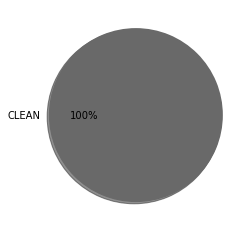

Stop write!


In [36]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# if df.isStreaming:
#     for x in range(0,2000):
#         try:
#             if not ds.isActive:
#                 print("Query is not active!")
#                 break
#             # display df to console
#             a = spark.sql(f"select * from {ds_count.name}").toPandas()
#             b = spark.sql(f"select * from {ds.name}").toPandas()
#             display(b)
#             plt.pie(a['count'],autopct = '%.0f%%',labels=a['sentiment'],
#                colors=['dimgrey','grey','silver'],shadow = True)
#             plt.show()
#             time.sleep(10)
#             clear_output(wait=True)
#         except KeyboardInterrupt:
#             print("Stop write!")
#             break

In [34]:
ds.stop()